In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

import numpy as np
from qaoa_OOP import *
from exactcover import *
from tailassignment_oop import * 
from tailassignment_loader import * 

import os

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

from qiskit.visualization import plot_histogram

In [3]:
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib as mpl
# from tqdm import tqdm

fontsize = 24
newparams = {'axes.titlesize': fontsize,
             'axes.labelsize': fontsize,
             'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 
             'legend.fontsize': fontsize,
             'figure.titlesize': fontsize,
             'legend.handlelength': 1.5, 
             'lines.linewidth': 2,
             'lines.markersize': 7,
             'figure.figsize': (12, 7), 
             'figure.dpi':200,
             'text.usetex' : False,
             'font.family' : "sans-serif"
            }

plt.rcParams.update(newparams)

In [ ]:
def averageQAOA(qaoa_type, options, simulation_args, num_route, num_sols, num_arr):
    flights = 24
    max_depth = simulation_args.get('max_depth',10)
    SP_all = np.zeros((len(num_sols), max_depth))
    C_all = np.zeros_like(SP_all)
    SP_avg = np.zeros(max_depth)
    C_avg = np.zeros_like(SP_avg)
    per_cent_best_cost = np.zeros((len(num_sols), max_depth))
    for i in range(len(num_sols)):
        print()
        print('Now using', num_sols[i], 'solutions, set number', num_arr[i])
        FR,CR = load_giorgio(f'./data/tail_assignment/Our_routes/Giorgio_routes_cost/FRCR_{num_route}_{flights}_{num_sols[i]}_{num_arr[i]}.npy')
        CR /= np.amax(CR)
        mu = np.amax(CR)
        options['FR'] = FR
        options['CR'] = CR
        options['mu'] = mu

        qaoa = qaoa_type(options)
        Elandscape, gammabetas, E, best = qaoa.simulate(**simulation_args)
        SP, C = qaoa.simulation_statistics(plot = False)
        best_cost = np.max( qaoa.vector_cost(qaoa.state_strings) )
        optimal_solution = qaoa.best_cost_string()
        state_strings = qaoa.state_strings 
        for k in range(1,max_depth+1):
            qaoa.depth = k
            circuit = qaoa.createCircuit(qaoa.params['xL_d' +str(k)])
            if qaoa.backend.configuration().local:
                job = execute(circuit, backend = qaoa.backend, noise_model = qaoa.noise_model, shots = qaoa.shots)
            else:
                job = start_or_retrieve_job(name +"_"+str(g_it), qaoa.backend, circuit, options = {'shots' : qaoa.shots})
            optimal_ind = np.where(state_strings==optimal_solution)
            per_cent_best_cost[i, k-1] = (np.abs(job.result().get_statevector())**2)[optimal_ind]


        SP_all[i] = SP
        print(-best_cost, -C)
        C_all[i] = C/best_cost
        SP_avg += SP/len(num_sols)
        C_avg += C/(len(num_sols)*best_cost)
        print(C_all, C_avg)
        print(SP_all, SP_avg)
    return SP_avg, SP_all, C_avg, C_all, per_cent_best_cost


In [20]:
num_routes = 7

options={}
options['usebarrier'] = True


beta_n    = 20
gamma_n   = 25
delta_n   = 25

beta_max  = np.pi
gamma_max = 2 * np.pi
delta_max = 2 * np.pi

optmethod = 'Nelder-Mead'
shots     = 1024 # no need for more shots when using the statevector simulation
rerun     = True
max_depth = 20

In [21]:
Aer.backends()
backend = Aer.get_backend('statevector_simulator')

In [22]:
simulation_args = dict()

simulation_args['backend']   = backend
simulation_args['optmethod'] = optmethod
simulation_args['max_depth'] = max_depth
simulation_args['repeats']   = 1
simulation_args['params_ll'] = np.array([0,0,0])
simulation_args['params_ul'] = np.array([gamma_max,beta_max,delta_max])
simulation_args['params_n']  = np.array([gamma_n, beta_n, delta_n])
simulation_args['shots']     = shots


In [23]:
options

{'usebarrier': True}

In [24]:
simulation_args

{'backend': StatevectorSimulator('statevector_simulator'),
 'optmethod': 'Nelder-Mead',
 'max_depth': 20,
 'repeats': 1,
 'params_ll': array([0, 0, 0]),
 'params_ul': array([6.28318531, 3.14159265, 6.28318531]),
 'params_n': array([25, 20, 25]),
 'shots': 1024}

In [25]:
sol_arr = np.array([3,3,3,3,3,3,4,4,4,4])
num_arr = np.array([1,2,3,4,5,6,1,2,3,4])

SP_avg, SP, C_avg, C, best_cost_overlap = averageQAOA(TailAssignmentInterlaced, options, simulation_args, num_routes, sol_arr, num_arr)


Now using 3 solutions, set number 1
Calculating energy landscape ...
Optimization terminated successfully.
         Current function value: 8.963195
         Iterations: 53
         Function evaluations: 99
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 8.963195
         Iterations: 25
         Function evaluations: 42
P = [0.31272002 2.66767357 1.60230999]
P_ = [0.31272002 2.66767357 1.60230999 0.31272002 2.66767357 1.60230999]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 8.526213
         Iterations: 226
         Function evaluations: 349
P = [0.29086231 2.71981502 1.32307298 0.43549713 3.03781181 1.82586034]
P_ = [0.29086231 2.71981502 1.32307298 0.36317972 2.87881341 1.57446666
 0.43549713 3.03781181 1.82586034]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 6.282966
         Iterations: 343
         Function evaluati

Optimization terminated successfully.
         Current function value: 1.945163
         Iterations: 5423
         Function evaluations: 6430
P = [ 0.33563718  2.42548978  2.38002998  0.06809098  3.08239758  0.85172961
  0.10210807  3.39876498  1.04745238  0.1597891   3.2077856   1.64182148
  0.11099075  3.02950442  1.58241673  0.11593745  2.96375471  1.66805552
  0.1835754   3.18501682  1.68849833  0.16316833  3.51821934  0.69642753
  0.25214452  2.80239429  0.60354771  0.75375984  3.25864036  0.25761338
  1.4625044   3.22103548 -0.4737451   2.61334928  3.14474182 -1.99431448
  3.28058982  3.24597872 -0.6747418 ]
P_ = [ 0.33563718  2.42548978  2.38002998  0.08867146  3.03186621  0.96929118
  0.09687467  3.35009307  1.01734118  0.14647809  3.25185777  1.50465938
  0.12600563  3.08436017  1.60069511  0.11403487  2.98904306  1.63511752
  0.15235788  3.08289585  1.67906318  0.17415675  3.3388026   1.2306195
  0.19738994  3.24290201  0.66070452  0.40648769  2.9427777   0.49710637
  0.91731

Optimization terminated successfully.
         Current function value: 1.727342
         Iterations: 6504
         Function evaluations: 7510
1.4444444444444444 [8.96319455 8.52621283 6.28296593 4.08270355 4.09090119 3.66008968
 3.59006463 3.45927379 2.57854881 2.57337692 2.36291787 2.79388967
 1.94516271 2.3340464  1.90267237 2.01326881 1.90853752 2.14528349
 1.72188166 1.72734175]
[[6.20528854 5.90276273 4.34974565 2.82648708 2.83216236 2.53390824
  2.48542936 2.39488186 1.78514917 1.78156864 1.63586622 1.93423131
  1.3466511  1.61587827 1.31723472 1.39380148 1.3212952  1.48519626
  1.19207192 1.19585198]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


Optimization terminated successfully.
         Current function value: 1.690816
         Iterations: 214
         Function evaluations: 324
P = [ 0.13800065  1.92586171 -0.43213112  0.30711742  1.83451563  0.04344176
  0.35971461  1.77006362 -0.05884196  0.41791864  1.73436051 -0.22628098
  0.44985795  1.69559604 -0.27223865  0.54427688  1.68112968 -0.20634549
  0.63025481  1.65664488 -0.10153944  0.6510978   1.62712077 -0.03879132]
P_ = [ 0.13800065  1.92586171 -0.43213112  0.28597782  1.84593389 -0.01600485
  0.34656531  1.78617662 -0.03327103  0.39609213  1.74774918 -0.16349135
  0.4338883   1.71497828 -0.24925982  0.48526505  1.69017116 -0.24752872
  0.56577136  1.67500848 -0.18014397  0.63286018  1.65295436 -0.09369592
  0.6510978   1.62712077 -0.03879132]
Depth = 9, Rep = 1
Optimization terminated successfully.
         Current function value: 1.549618
         Iterations: 2320
         Function evaluations: 2871
P = [ 0.13070469  1.96690965 -0.37162686  0.27454446  1.78473138 -0

Optimization terminated successfully.
         Current function value: 1.022240
         Iterations: 1321
         Function evaluations: 1705
P = [ 0.03946379  1.95487467 -1.19020552  0.15664938  1.88824394 -2.07918298
  0.07149722  1.60236963 -0.18497619  0.20214726  1.76432647 -2.75720813
  0.27369996  1.75276083 -2.51434078  0.30303907  1.75164928 -2.44164383
  0.31471398  1.72085925 -2.08131831  0.3338603   1.71645702 -1.60789796
  0.34118491  1.70506433 -1.34512975  0.36803836  1.70335154 -1.13569654
  0.41447497  1.68110307 -0.68765559  0.44811014  1.6669401  -0.13897143
  0.4603114   1.6357904  -0.1489278   0.51311119  1.63946579 -0.42184046
  0.55976184  1.62242262 -0.58313555  0.57753044  1.61225463  0.05180412]
P_ = [ 0.03946379  1.95487467 -1.19020552  0.14932528  1.89240836 -2.02362189
  0.08214124  1.63810392 -0.42175204  0.17765038  1.73395957 -2.27491464
  0.25581179  1.75565224 -2.57505762  0.2938706   1.75199664 -2.46436163
  0.31033589  1.73240551 -2.21644038  0.32548

Optimization terminated successfully.
         Current function value: 7.582433
         Iterations: 76
         Function evaluations: 133
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 7.582433
         Iterations: 18
         Function evaluations: 35
P = [ 0.32081448  2.01979286 -0.32070449]
P_ = [ 0.32081448  2.01979286 -0.32070449  0.32081448  2.01979286 -0.32070449]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 5.243458
         Iterations: 109
         Function evaluations: 175
P = [ 0.1903835   1.79246955 -0.34115475  0.41965285  1.86446194 -0.27869995]
P_ = [ 0.1903835   1.79246955 -0.34115475  0.30501817  1.82846574 -0.30992735
  0.41965285  1.86446194 -0.27869995]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 4.640055
         Iterations: 145
         Function evaluations: 219
P = [ 0.16461571  1.98443818 -0.3707

P = [ 0.07464087  2.04623679  0.10210785  0.19508765  1.93120639 -0.89113435
  0.30137603  1.87283564 -0.34186382  0.3370354   1.83740901 -2.20026748
  0.34657022  1.75696334 -0.62953457  0.32790803  1.77022858 -1.55390508
  0.38154497  1.7890616  -1.46628098  0.4357355   1.75429041 -0.64412083
  0.44329641  1.70882185 -0.64975626  0.46914373  1.65352341 -0.64295977
  0.54466961  1.70978174 -0.16383734  0.6110678   1.6573369  -0.12289987
  0.60077656  1.64482487  0.11293546]
P_ = [ 0.07464087  2.04623679  0.10210785  0.18582251  1.94005488 -0.8147311
  0.28502397  1.88181576 -0.42636698  0.32880631  1.84558438 -1.7714051
  0.34363643  1.78171585 -1.11283701  0.33508579  1.76512656 -1.19837796
  0.35678946  1.78036944 -1.50672287  0.40655599  1.77301336 -1.08682245
  0.43864354  1.7368025  -0.6462883   0.45124943  1.69180694 -0.64766503
  0.48657278  1.6665061  -0.53239305  0.55488471  1.70171331 -0.15753927
  0.61027616  1.65637444 -0.10475869  0.60077656  1.64482487  0.11293546]
Depth

Optimization terminated successfully.
         Current function value: 1.484554
         Iterations: 3114
         Function evaluations: 3733
1.3571428571428572 [7.58243337 5.24345812 4.64005483 3.98561262 3.24406278 2.73079183
 2.42949298 2.13406874 2.00066273 1.98499101 1.93919192 1.85096231
 1.62002947 1.5596317  1.53578071 1.52298198 1.51265038 1.50438675
 1.49217229 1.48455378]
[[6.20528854 5.90276273 4.34974565 2.82648708 2.83216236 2.53390824
  2.48542936 2.39488186 1.78514917 1.78156864 1.63586622 1.93423131
  1.3466511  1.61587827 1.31723472 1.39380148 1.3212952  1.48519626
  1.19207192 1.19585198]
 [7.30404471 4.53202785 3.46764965 2.88567087 2.50354724 2.12413704
  1.93259722 1.8208787  1.66881973 1.61137624 1.5777798  1.52441689
  1.50488971 1.32477289 1.14366376 1.10087346 1.06542039 1.04874467
  1.03100111 1.02313941]
 [5.58705617 3.86360072 3.41898777 2.93676719 2.39036205 2.0121624
  1.79015272 1.5724717  1.47417254 1.46262495 1.42887826 1.36386696
  1.19370592 1.149202

P = [ 6.21198378e+00  1.14255281e+00  2.97516031e-02  6.08847059e+00
  1.19467544e+00  2.31180583e-02  6.01330395e+00  1.39924429e+00
 -4.16116843e-03  5.94810599e+00  1.36242126e+00  3.58091329e-01
  5.95059464e+00  1.46463583e+00  2.12243635e-01  5.84390954e+00
  1.43989462e+00  3.94924840e-01  5.65032276e+00  1.48016688e+00
  2.72661691e-01]
P_ = [6.21198378e+00 1.14255281e+00 2.97516031e-02 6.10611533e+00
 1.18722935e+00 2.40657076e-02 6.03478013e+00 1.34079605e+00
 3.63289635e-03 5.97604797e+00 1.37820256e+00 2.02840259e-01
 5.94917256e+00 1.40622750e+00 2.95585175e-01 5.92011319e+00
 1.45756691e+00 2.64438265e-01 5.81625428e+00 1.44564780e+00
 3.77458676e-01 5.65032276e+00 1.48016688e+00 2.72661691e-01]
Depth = 8, Rep = 1
Optimization terminated successfully.
         Current function value: 2.726083
         Iterations: 2607
         Function evaluations: 3290
P = [ 6.18915144e+00  1.24314063e+00  7.29893236e-02  6.04798634e+00
  1.15164160e+00  5.23996824e-02  6.00283804e+00  1

P = [ 6.19810559e+00  1.19299414e+00 -4.98494679e-02  6.09621330e+00
  1.15965101e+00  1.00110725e-01  6.07618799e+00  1.35377748e+00
  2.31476773e-04  6.04995841e+00  1.28760436e+00  1.43344020e+00
  6.02923643e+00  1.39695481e+00  2.72483366e-01  6.02030246e+00
  1.31101820e+00  1.47309500e+00  5.99230872e+00  1.40075775e+00
  1.32491585e+00  6.07895473e+00  1.43146274e+00 -3.81750453e-01
  6.06605788e+00  1.48154610e+00  1.37984221e+00  5.97876661e+00
  1.42255088e+00 -8.20315878e-02  5.88851699e+00  1.46018426e+00
  1.20827509e-01  5.95209841e+00  1.47853586e+00  8.90463175e-02
  5.77390407e+00  1.50162137e+00  4.53571343e-02  5.56836870e+00
  1.43524596e+00  1.70980815e-01  5.56335675e+00  1.53030031e+00
 -2.72463989e-04  5.57050768e+00  1.47645322e+00 -7.35071898e-03]
P_ = [ 6.19810559e+00  1.19299414e+00 -4.98494679e-02  6.10258157e+00
  1.16173496e+00  9.07382129e-02  6.07869116e+00  1.32951167e+00
  1.27163828e-02  6.05487646e+00  1.30001182e+00  1.16471356e+00
  6.03441692e+0

Optimization terminated successfully.
         Current function value: 11.144350
         Iterations: 62
         Function evaluations: 113
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 11.144350
         Iterations: 30
         Function evaluations: 51
P = [1.97725339 2.50054176 6.56111627]
P_ = [1.97725339 2.50054176 6.56111627 1.97725339 2.50054176 6.56111627]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 7.520118
         Iterations: 428
         Function evaluations: 659
P = [ 1.97633312  2.49347932  6.71296349  1.65810579  2.89313612 14.09988284]
P_ = [ 1.97633312  2.49347932  6.71296349  1.81721945  2.69330772 10.40642316
  1.65810579  2.89313612 14.09988284]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 5.473465
         Iterations: 587
         Function evaluations: 854
P = [ 2.22608562  2.48309526  6.3751938   1

P = [ 2.10431242  2.41829165  5.19551743  2.09495903  2.77062276  9.56823313
  1.90308989  2.97431965  8.0775026   2.04061924  2.95514489  8.43010783
  1.62696784  2.81928147 10.32722534  1.70827499  2.80973857 12.43914084
  1.82246376  2.86591105 12.11366701  1.88614565  2.93815435  9.79801862
  1.79991626  3.00224841  8.3608707   1.83693368  2.98199016  7.24878011
  1.9488327   2.95173778 10.88279709  2.09615283  3.00492809 12.18854954
  2.23335016  3.02967199  7.77699157  1.97220343  3.0542084  10.15729589]
P_ = [ 2.10431242  2.41829165  5.19551743  2.09562713  2.74545625  9.25589629
  1.93049977  2.94522009  8.29046411  2.01114866  2.95925377  8.35454956
  1.74515395  2.85809959  9.78519176  1.67923672  2.81314675 11.6848853
  1.77352572  2.84183713 12.25315579  1.85430471  2.9020327  10.95584281
  1.8491902   2.96562323  9.18209808  1.81313677  2.99501332  7.96369549
  1.86890483  2.97334662  8.28707068  1.9804013   2.9631357  11.16260119
  2.11575245  3.00846293 11.55832698  2.21

Optimization terminated successfully.
         Current function value: 9.491659
         Iterations: 70
         Function evaluations: 128
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 9.491659
         Iterations: 17
         Function evaluations: 34
P = [0.22867351 1.96993302 0.32564453]
P_ = [0.22867351 1.96993302 0.32564453 0.22867351 1.96993302 0.32564453]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 6.048405
         Iterations: 109
         Function evaluations: 175
P = [0.2081537  1.73111324 0.32025028 0.42129876 1.84668442 0.13550886]
P_ = [0.2081537  1.73111324 0.32025028 0.31472623 1.78889883 0.22787957
 0.42129876 1.84668442 0.13550886]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 4.352686
         Iterations: 251
         Function evaluations: 374
P = [0.1657956  1.92305118 0.1810702  0.35776412 1.67413717 

Optimization terminated successfully.
         Current function value: 2.596498
         Iterations: 887
         Function evaluations: 1161
P = [ 0.09410201  1.80781033 -0.81605315  0.20575219  1.84585976 -0.04772781
  0.10246287  1.56886923 -0.1158574   0.19796195  1.72061646 -0.95205972
  0.27128326  1.73825819 -1.03853704  0.29093622  1.73589818 -0.74114385
  0.31312153  1.72348348 -0.46140512  0.31672414  1.70260608 -0.14013824
  0.31495794  1.70385046 -0.04287319  0.33610014  1.68105774 -0.03306623
  0.35944866  1.65983321  0.07150472  0.42446379  1.62838614  0.14914043
  0.44492428  1.62450318  0.47598328]
P_ = [ 0.09410201  1.80781033 -0.81605315  0.19716372  1.84293288 -0.10682976
  0.11835353  1.61148316 -0.10537592  0.1759237   1.68559787 -0.75908996
  0.24872286  1.73282997 -1.01192864  0.28337739  1.73680588 -0.85552585
  0.30288215  1.72921335 -0.5905153   0.31478427  1.71384776 -0.3131281
  0.31604483  1.70308469 -0.10272861  0.32146323  1.69683732 -0.03985567
  0.341488

Optimization terminated successfully.
         Current function value: 2.468053
         Iterations: 1102
         Function evaluations: 1463
2.4285714285714284 [9.49165903 6.04840458 4.35268578 3.80965479 3.64641091 3.33322723
 3.12090875 3.00446248 2.98040658 2.88390517 2.71404212 2.64148713
 2.59649843 2.57514437 2.54557446 2.51290704 2.49344616 2.47862478
 2.4711684  2.46805344]
[[6.20528854 5.90276273 4.34974565 2.82648708 2.83216236 2.53390824
  2.48542936 2.39488186 1.78514917 1.78156864 1.63586622 1.93423131
  1.3466511  1.61587827 1.31723472 1.39380148 1.3212952  1.48519626
  1.19207192 1.19585198]
 [7.30404471 4.53202785 3.46764965 2.88567087 2.50354724 2.12413704
  1.93259722 1.8208787  1.66881973 1.61137624 1.5777798  1.52441689
  1.50488971 1.32477289 1.14366376 1.10087346 1.06542039 1.04874467
  1.03100111 1.02313941]
 [5.58705617 3.86360072 3.41898777 2.93676719 2.39036205 2.0121624
  1.79015272 1.5724717  1.47417254 1.46262495 1.42887826 1.36386696
  1.19370592 1.149202

Optimization terminated successfully.
         Current function value: 2.294351
         Iterations: 327
         Function evaluations: 492
P = [6.09187033 1.22064682 0.04561432 5.8365256  1.24473741 0.07005804
 5.7258587  1.29755363 0.09634462 5.63715359 1.35492249 0.12405028
 5.59420013 1.39311944 0.15451217 5.60597275 1.44619168 0.18288017
 5.54427862 1.49966199 0.21616201 5.55842298 1.52208488 0.25851257]
P_ = [6.09187033 1.22064682 0.04561432 5.86844369 1.24172609 0.06700257
 5.75352543 1.28434957 0.08977298 5.67041801 1.33340917 0.11366066
 5.61567686 1.37402097 0.13928122 5.59861486 1.41302153 0.16515017
 5.59054922 1.45955925 0.19120063 5.54604667 1.50246485 0.22145583
 5.55842298 1.52208488 0.25851257]
Depth = 9, Rep = 1
Optimization terminated successfully.
         Current function value: 2.267907
         Iterations: 314
         Function evaluations: 488
P = [6.10313275 1.20275372 0.04474845 5.8641031  1.25196073 0.06752431
 5.75162608 1.29248239 0.09082257 5.67242315 1.34

Optimization terminated successfully.
         Current function value: 1.594733
         Iterations: 8701
         Function evaluations: 10072
P = [ 6.19140977e+00  1.47243647e+00 -1.72115726e-04  5.87968673e+00
  1.30055173e+00 -1.52397761e-02  5.69154356e+00  1.20625127e+00
  3.96269823e-02  5.60655632e+00  1.31904135e+00 -1.52593167e-01
  5.65556668e+00  1.39431061e+00  5.42828913e-01  5.85909612e+00
  1.41816935e+00  2.46246913e-01  5.66450678e+00  1.42473788e+00
  8.29841689e-01  5.55182002e+00  1.45128328e+00  9.69049826e-01
  5.53456436e+00  1.46026714e+00  7.06653896e-01  5.63397817e+00
  1.33089777e+00  6.01387342e-01  5.80027315e+00  1.30581655e+00
 -2.01739279e-01  5.88279708e+00  1.28216135e+00  1.44300566e-01
  5.78138483e+00  1.31709203e+00  1.39058444e-02  5.86046635e+00
  1.38057549e+00 -8.34547964e-03  5.24443207e+00  1.63462989e+00
  1.14352585e-01  7.00572604e+00  1.41395968e+00  2.70312109e-03
  3.66974584e+00  1.59733329e+00  5.66936524e-01]
P_ = [ 6.19140977e+00  

Optimization terminated successfully.
         Current function value: 6.451504
         Iterations: 101
         Function evaluations: 181
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 6.451504
         Iterations: 12
         Function evaluations: 25
P = [ 0.31737312  0.3917661  -0.22473548]
P_ = [ 0.31737312  0.3917661  -0.22473548  0.31737312  0.3917661  -0.22473548]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 4.687726
         Iterations: 59
         Function evaluations: 99
P = [ 0.26103363  0.26265899 -0.25919057  0.49223753  0.22903985 -0.23204621]
P_ = [ 0.26103363  0.26265899 -0.25919057  0.37663558  0.24584942 -0.24561839
  0.49223753  0.22903985 -0.23204621]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 2.711834
         Iterations: 197
         Function evaluations: 280
P = [ 0.32763762  0.44317961 -0.27418

Optimization terminated successfully.
         Current function value: 1.142667
         Iterations: 950
         Function evaluations: 1205
P = [ 0.06032212  0.39610555 -0.54553297  0.13873957  0.3889279  -0.95478005
  0.18277864  0.32778035 -1.58176111  0.25253805  0.29681311 -1.66244138
  0.29393872  0.26559844 -1.58455497  0.35163271  0.26486394 -1.52363663
  0.40936072  0.27324986 -1.28858268  0.47642609  0.24526687 -0.9687769
  0.55468683  0.20169322 -0.46511286  0.60479568  0.15292603 -0.28141527
  0.60685074  0.11231372 -0.01547786  0.6078747   0.05947154  0.19416086
  0.69888473  0.05532586  0.01941206]
P_ = [ 0.06032212  0.39610555 -0.54553297  0.13270745  0.38948003 -0.9232995
  0.1760034   0.33718766 -1.48530248  0.23643973  0.3039594  -1.64382285
  0.28120005  0.27520295 -1.60852002  0.32944272  0.26514644 -1.54706677
  0.38271702  0.26937943 -1.39706912  0.44031397  0.26033463 -1.14098001
  0.50652637  0.22850777 -0.77505996  0.57010493  0.18668793 -0.40859052
  0.6052699

Optimization terminated successfully.
         Current function value: 1.135676
         Iterations: 978
         Function evaluations: 1333
1.0666666666666667 [6.45150366 4.68772586 2.71183378 2.32194295 2.01472992 1.86445575
 1.42298426 1.20366917 1.17246137 1.16212741 1.15145871 1.1472943
 1.1426673  1.14104748 1.13894396 1.13851361 1.13685106 1.13706497
 1.13591528 1.13567623]
[[6.20528854 5.90276273 4.34974565 2.82648708 2.83216236 2.53390824
  2.48542936 2.39488186 1.78514917 1.78156864 1.63586622 1.93423131
  1.3466511  1.61587827 1.31723472 1.39380148 1.3212952  1.48519626
  1.19207192 1.19585198]
 [7.30404471 4.53202785 3.46764965 2.88567087 2.50354724 2.12413704
  1.93259722 1.8208787  1.66881973 1.61137624 1.5777798  1.52441689
  1.50488971 1.32477289 1.14366376 1.10087346 1.06542039 1.04874467
  1.03100111 1.02313941]
 [5.58705617 3.86360072 3.41898777 2.93676719 2.39036205 2.0121624
  1.79015272 1.5724717  1.47417254 1.46262495 1.42887826 1.36386696
  1.19370592 1.14920231

Optimization terminated successfully.
         Current function value: 2.462205
         Iterations: 152
         Function evaluations: 226
P = [ 0.18559449  0.39617316 -0.1369624   0.4356239   0.35458799 -0.13697053
  0.54405624  0.33705636 -0.12634052  0.65805372  0.28890678 -0.10299706
  0.72061005  0.25269663 -0.08902165  0.73521613  0.17195892 -0.07284634
  0.76213598  0.108293   -0.05555203]
P_ = [ 0.18559449  0.39617316 -0.1369624   0.39990541  0.36052873 -0.13696936
  0.51307557  0.34206539 -0.12937767  0.60919766  0.30954231 -0.1130014
  0.68486357  0.27338814 -0.09700759  0.72478321  0.22962871 -0.08440013
  0.73906183  0.16286379 -0.07037572  0.76213598  0.108293   -0.05555203]
Depth = 8, Rep = 1
Optimization terminated successfully.
         Current function value: 2.444359
         Iterations: 132
         Function evaluations: 209
P = [ 0.18251059  0.39251803 -0.12987721  0.40610364  0.36581535 -0.13954004
  0.52776845  0.33599867 -0.13199664  0.59439525  0.3050962  -0.11

Optimization terminated successfully.
         Current function value: 2.350999
         Iterations: 928
         Function evaluations: 1155
P = [ 0.14257586  0.36650947 -0.10326173  0.2982176   0.30755044 -0.1103425
  0.36774263  0.3453603  -0.18184979  0.44875801  0.35560058 -0.16857854
  0.532757    0.36570586 -0.18570373  0.55391226  0.36156854 -0.20240794
  0.57463217  0.35869422 -0.13339129  0.61254498  0.30447639 -0.1337445
  0.64354929  0.29065482 -0.10702713  0.6651811   0.26308964 -0.09706607
  0.66144104  0.20964688 -0.08910133  0.67596923  0.20083133 -0.09046651
  0.72620295  0.1894421  -0.09143695  0.74737398  0.16759222 -0.07218019
  0.7827553   0.09662268 -0.06843135  0.83198078  0.04320714 -0.06179649]
P_ = [ 0.14257586  0.36650947 -0.10326173  0.28848999  0.31123538 -0.10989995
  0.359052    0.34063407 -0.17291138  0.43356762  0.35368053 -0.1710669
  0.51175725  0.36317954 -0.18142244  0.54730124  0.36286145 -0.19718787
  0.56686221  0.35977209 -0.15927253  0.59595813 

Optimization terminated successfully.
         Current function value: 6.781526
         Iterations: 103
         Function evaluations: 180
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 6.781526
         Iterations: 13
         Function evaluations: 26
P = [ 0.33240471  0.39234587 -0.60216272]
P_ = [ 0.33240471  0.39234587 -0.60216272  0.33240471  0.39234587 -0.60216272]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 4.608862
         Iterations: 268
         Function evaluations: 396
P = [ 0.26534371  0.24040796 -0.09872448  0.48926034  0.24494531 -0.50119969]
P_ = [ 0.26534371  0.24040796 -0.09872448  0.37730202  0.24267664 -0.29996208
  0.48926034  0.24494531 -0.50119969]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 3.607445
         Iterations: 206
         Function evaluations: 309
P = [ 0.24343261  0.39655699 -0.114

Optimization terminated successfully.
         Current function value: 1.003299
         Iterations: 6328
         Function evaluations: 7460
P = [ 0.00813477  0.11944068 -0.43926129  0.09277533  0.35734808 -0.36901783
  0.22299349  0.41041771 -1.80882363  0.31913375  0.3293801  -3.22569903
  0.39490146  0.25731453 -3.65940458  0.38263145  0.22257435 -3.20578081
  0.41460204  0.31306652 -3.88507608  0.33827254  0.31550811 -4.55411448
  0.32956206  0.26140973 -4.55438303  0.21174233  0.12343548 -3.37473807
  0.25688718  0.11852399 -2.69141462  0.32834413  0.0880752  -2.37281896
  0.37114732  0.07211994 -3.04205118  0.53246624  0.03744112 -3.76455093]
P_ = [ 0.00813477  0.11944068 -0.43926129  0.08672958  0.3403547  -0.37403522
  0.20439089  0.40283634 -1.60313709  0.29853227  0.3467453  -2.92208287
  0.37325355  0.2779047  -3.53548871  0.3870136   0.23498156 -3.3677893
  0.40090036  0.27428416 -3.59394954  0.37643729  0.31428731 -4.21959528
  0.33453948  0.29232309 -4.55422957  0.287483

Optimization terminated successfully.
         Current function value: 1.000992
         Iterations: 1502
         Function evaluations: 1956
1.0 [6.78152592 4.60886198 3.60744455 3.01730702 2.62699999 2.18354325
 1.858517   1.66753139 1.57556942 1.34783355 1.07732346 1.01732235
 1.0127981  1.00329886 1.0015788  1.00119039 1.00145445 1.00070039
 1.00086837 1.00099187]
[[6.20528854 5.90276273 4.34974565 2.82648708 2.83216236 2.53390824
  2.48542936 2.39488186 1.78514917 1.78156864 1.63586622 1.93423131
  1.3466511  1.61587827 1.31723472 1.39380148 1.3212952  1.48519626
  1.19207192 1.19585198]
 [7.30404471 4.53202785 3.46764965 2.88567087 2.50354724 2.12413704
  1.93259722 1.8208787  1.66881973 1.61137624 1.5777798  1.52441689
  1.50488971 1.32477289 1.14366376 1.10087346 1.06542039 1.04874467
  1.03100111 1.02313941]
 [5.58705617 3.86360072 3.41898777 2.93676719 2.39036205 2.0121624
  1.79015272 1.5724717  1.47417254 1.46262495 1.42887826 1.36386696
  1.19370592 1.14920231 1.13162789 1

In [26]:
print(best_cost_overlap)

[[0.12916193 0.1405906  0.20825739 0.3946113  0.33802979 0.35459621
  0.31621434 0.37980233 0.58538241 0.63536451 0.77815653 0.60759129
  0.72760674 0.63736704 0.82640758 0.72064467 0.76527415 0.78165875
  0.75232462 0.86160072]
 [0.07339238 0.15544793 0.21481257 0.25442134 0.29076059 0.32998113
  0.34412803 0.35695075 0.36801542 0.38040556 0.38253663 0.38368893
  0.38517755 0.58597231 0.73470571 0.75354011 0.76371667 0.7812745
  0.84952851 0.87321511]
 [0.06347722 0.10362987 0.12416638 0.16755845 0.24925607 0.31775773
  0.34156821 0.38418093 0.39254043 0.39441383 0.41040484 0.51042819
  0.61778584 0.64676662 0.66836731 0.68471078 0.7002794  0.71788741
  0.73247389 0.74812819]
 [0.06714036 0.12041733 0.18018107 0.20956946 0.22311392 0.23533142
  0.26587805 0.28808192 0.30368657 0.30943559 0.31896882 0.33189597
  0.33983731 0.40695008 0.53995056 0.64957422 0.70449487 0.72366793
  0.73745082 0.75599367]
 [0.10910998 0.19251708 0.35175904 0.54754993 0.32660484 0.45488914
  0.43285086 0.47

[0.07804417 0.14575789 0.2158046  0.27833488 0.27535387 0.3232685
 0.35362498 0.38310905 0.4233661  0.44957636 0.49127696 0.49220696
 0.52519921 0.55266831 0.61276705 0.64063941 0.70141853 0.72892296
 0.73972429 0.75964685]


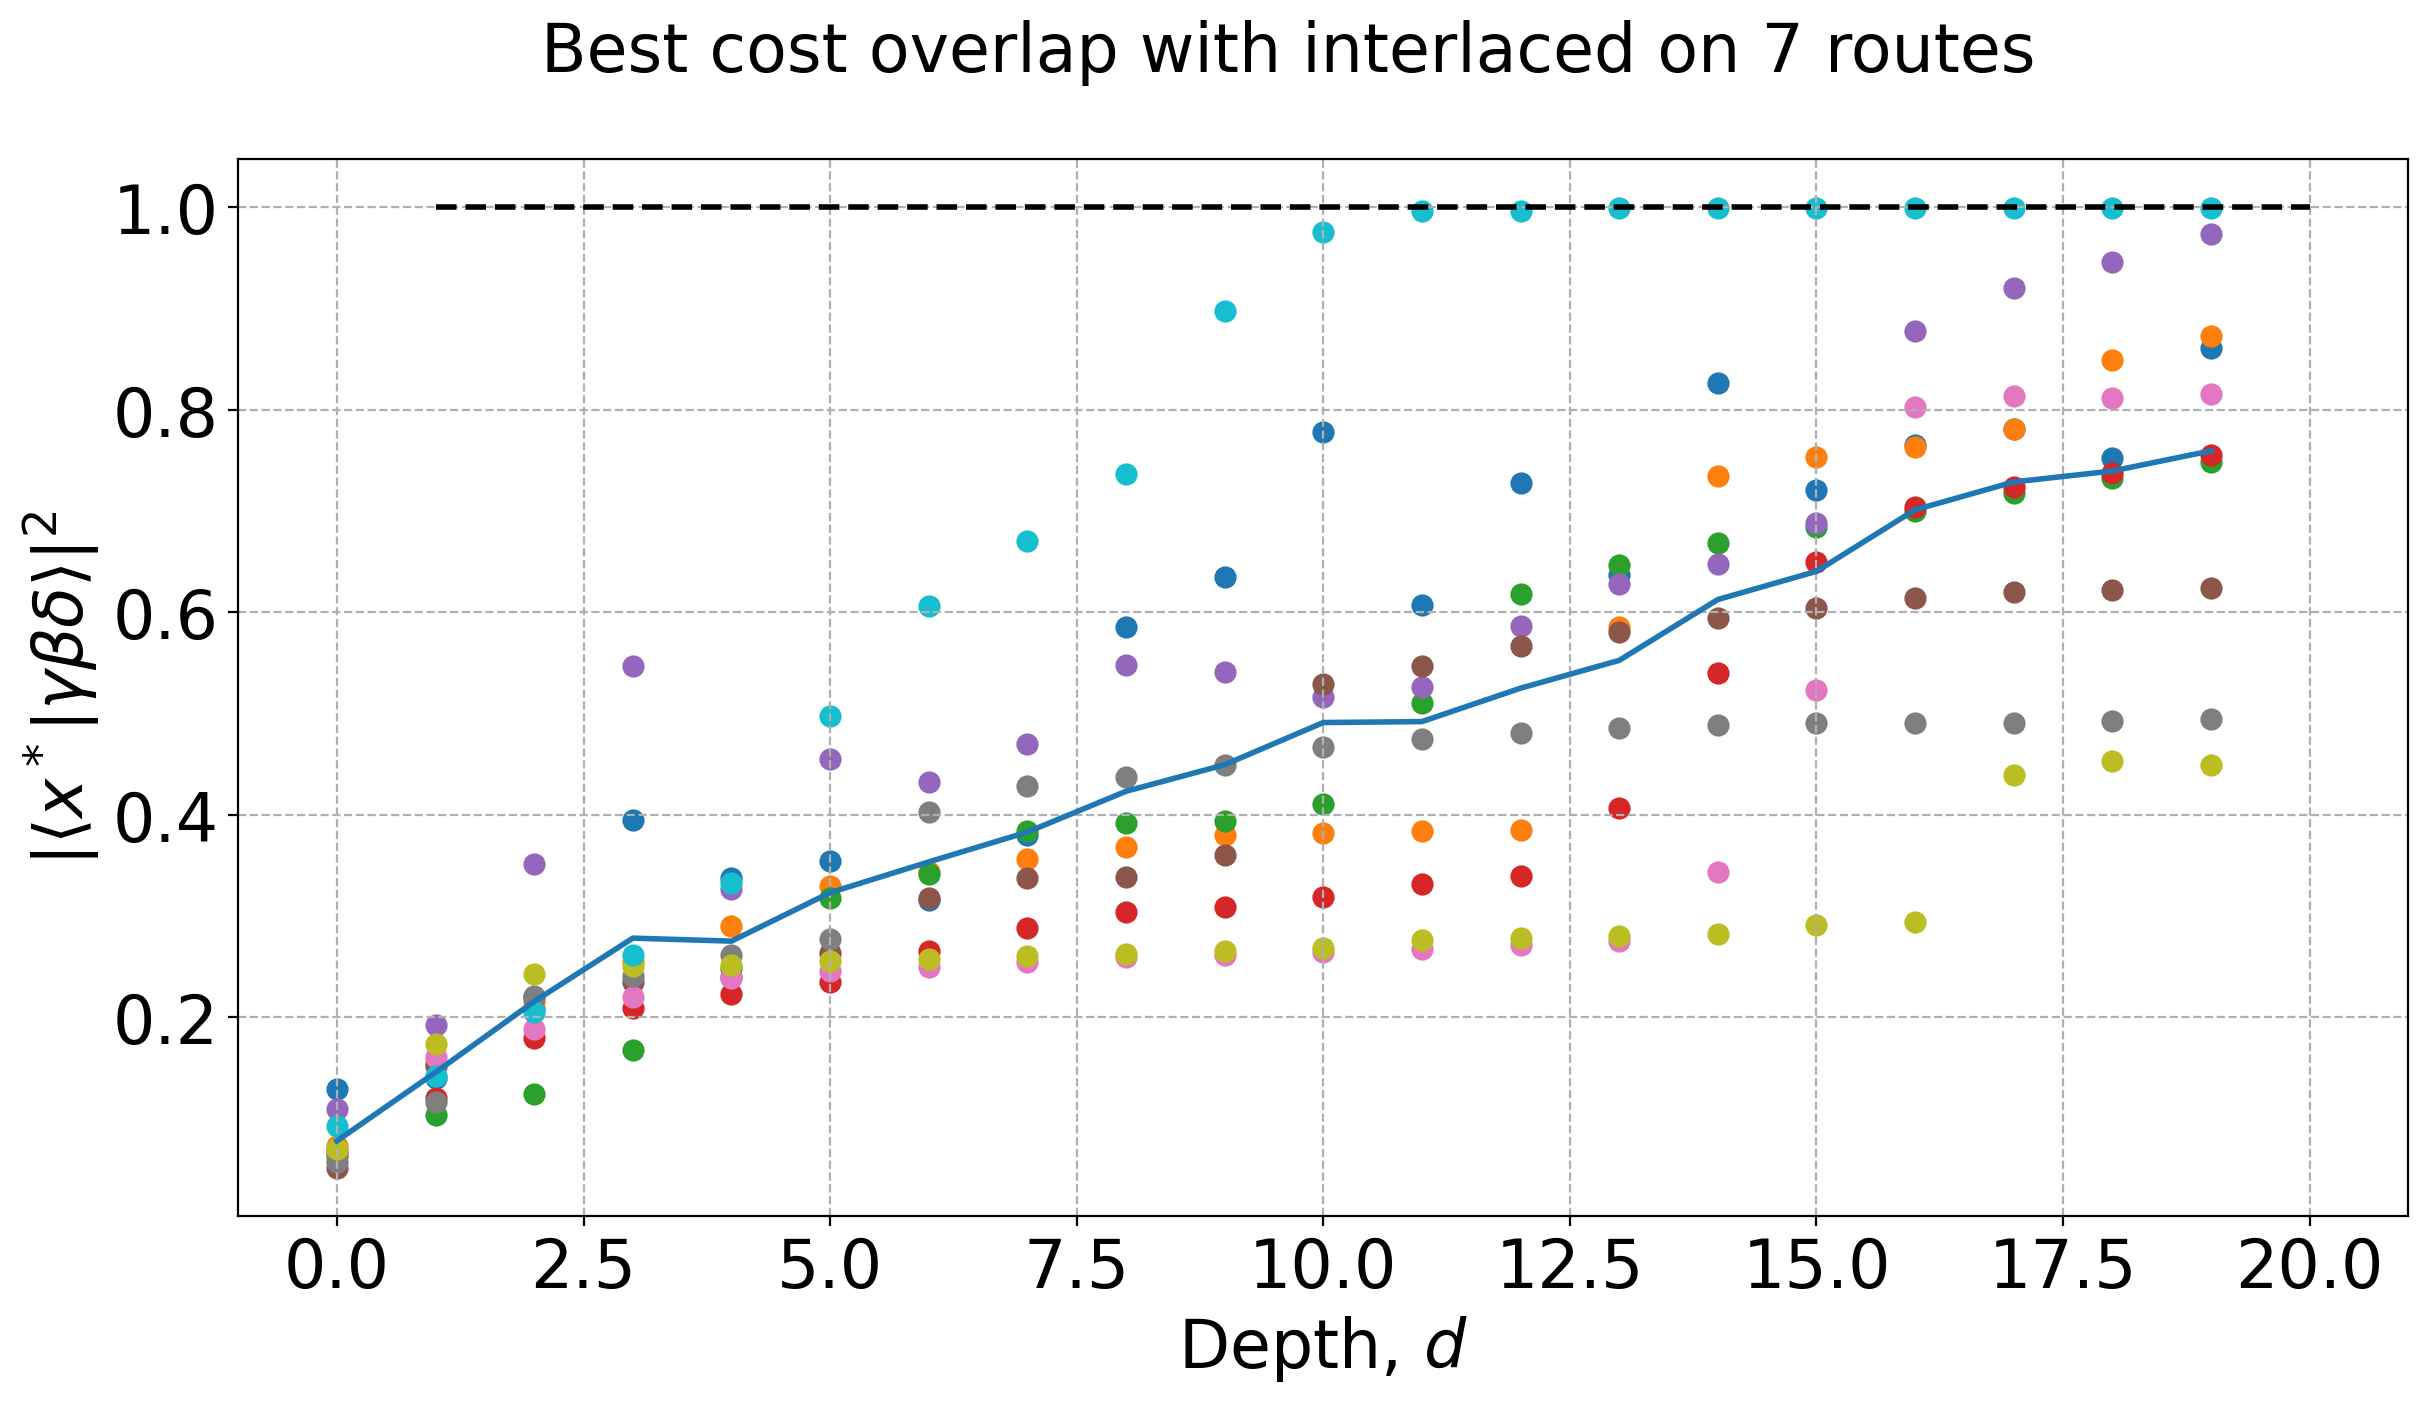

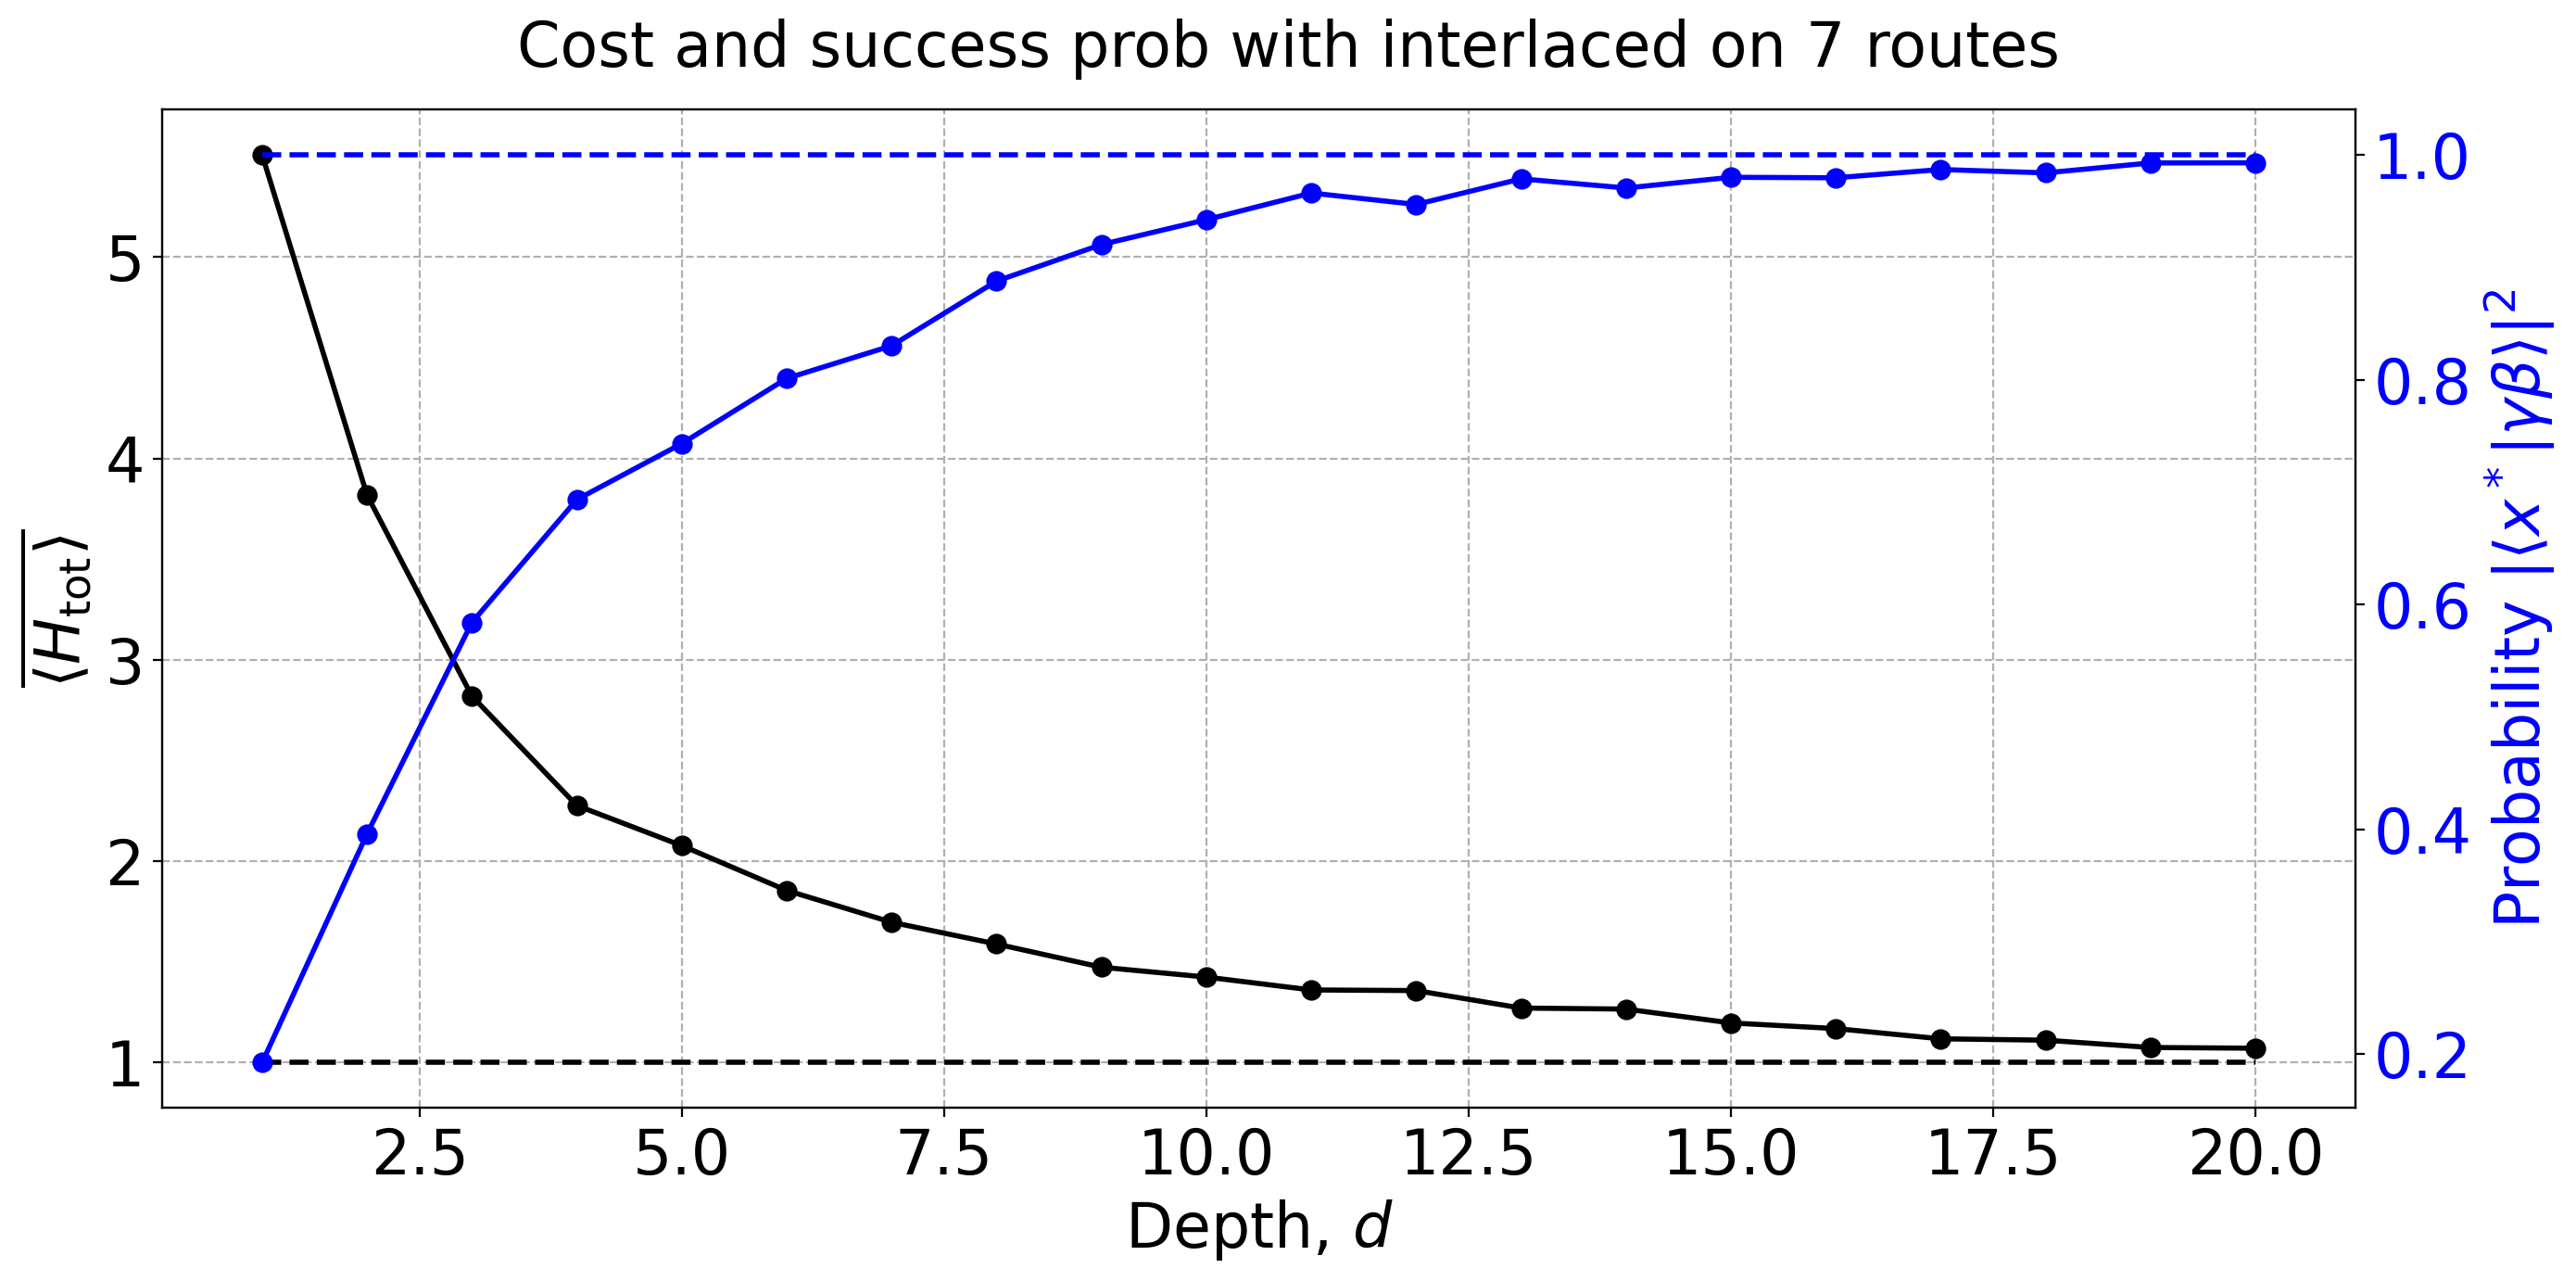

In [53]:
print(np.sum(best_cost_overlap,axis=0)/10)
fig, ax = plt.subplots(figsize  = (14,7))
fig.suptitle(f'Best cost overlap with interlaced on {num_routes} routes')
ax.plot(range(best_cost_overlap.shape[1]), np.sum(best_cost_overlap,axis=0)/10)
for i in range(10):
    ax.scatter(range(best_cost_overlap.shape[1]), best_cost_overlap[i])
ax.hlines(1,1,max_depth,color = "black", ls = "--")
ax.grid(ls = "--")
ax.set_ylabel(r"$|{\langle x^* |\gamma \beta \delta \rangle}|^2$", color = "black")
ax.set_xlabel("Depth, $d$")
plt.savefig(f'./data/saved_histograms/Averages/Best cost overlap with interlaced on {num_routes} routes high sol.pdf')
plt.show()
plot_SP_C(SP_avg, C_avg, max_depth , title = f'Cost and success prob with interlaced on {num_routes} routes', savefig = f'./data/saved_histograms/Averages/Cost and success prob with interlaced high sol on {num_routes} routes maxdepth {max_depth}.pdf')

In [47]:
np.save(f'./data/saved_probs_costs/Interlaced_average_cost_{num_routes}_routes_{max_depth}_depth_high_sol', C_avg)
np.save(f'./data/saved_probs_costs/Interlaced_average_success_prob_{num_routes}_routes_{max_depth}_depth_high_sol', SP_avg)
np.save(f'./data/saved_probs_costs/Interlaced_cost_{num_routes}_routes_{max_depth}_depth_high_sol', C)
np.save(f'./data/saved_probs_costs/Interlaced_success_prob_{num_routes}_routes_{max_depth}_depth_high_sol', SP)
np.save(f'./data/saved_probs_costs/Interlaced_best_cost_overlap_{num_routes}_routes_{max_depth}_depth_high_sol', best_cost_overlap)